## Data generator example
---

Example showing how to create a PyTorch compatible generator which windows trace data and applies standard data augmentation steps. 

Data generation API also uses function-based decorators to allow user to easily construct data augmentation and processing pipelines. Example usage is also shown below.

***Current version of the data generator code is incomplete and subject to change**

In [1]:
import torch
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import seisbench.data
import numpy as np

Get dummy dataset:

In [2]:
dummy = seisbench.data.DummyDataset()
print(dummy)

DummyDataset - 100 traces


Create training/label example generator object.

In [3]:
from seisbench.generate import GenericGenerator, SlidingWindow, Normalize

generator = GenericGenerator(dataset=dummy)
generator

Apply some simple processing steps. The ```GenericGenerator``` instance takes a single argument _dataset_ (a SeisBench dataset), and makes it compatible with and inherit the functionality a PyTorch Dataset object. This allows you to wrap the GenericGenerator in a PyTorch DataLoader the same as any other PyTorch Dataset class - giving multiprocessing, batch-loading, shuffling functionality.

Internally, ```GenericGenerator``` also ensures any processing methods applied are tracked through the objects state. Processing operations are applied recursively when __getitem__ is called. All users' need to do pass their augmentations to ```generator.augmentation``` or use the ```@generator.augmentation``` decorator.

Below we add some standard processing steps to apply to the raw waveform data. For each processing step, the method modifies the _state_dict_ which is naturally a dictionary of the current objects state up until this point. We use three customizable augmentations from the SeisBench library and one self implemented augmentation.

In [4]:
generator.augmentation(SlidingWindow(timestep=300))
generator.augmentation(Normalize(demean_axis=-1, amp_norm_axis=-1, amp_norm_type="std"))

@generator.augmentation
def times_two(state_dict):
    state_dict['X'] *= 2

As dicussed, wrap dataset in PyTorch DataLoader yielding batches of 5 example waveforms each time. Each example will have processing steps applied (so should be 600 sample windows, stepped along).

In [5]:
# Wrap generator in PyTorch DataLoader
train_loader = torch.utils.data.DataLoader(
    dataset=generator, 
    batch_size=5, 
    pin_memory=True, 
    shuffle=False
)

Each call of ```__getitem__``` adds training and label data to the state_dict which is then returned upon each iteration of the dataloader. 

In [6]:
for train_data in train_loader:
    break

train_data.keys()

/home/yetinam/anaconda3/envs/seisbench/lib/python3.8/site-packages/torch/cuda/__init__.py:52: UserWarning: CUDA initialization: Found no NVIDIA driver on your system. Please check that you have an NVIDIA GPU and installed a driver from http://www.nvidia.com/Download/index.aspx (Triggered internally at  /pytorch/c10/cuda/CUDAFunctions.cpp:100.)
  return torch._C._cuda_getDeviceCount() > 0


dict_keys(['waveforms', 'metadata', 'X', 'y'])

You can also see what processing methods were applied directly in the GenericGenerator

In [7]:
print(generator)

GenericGenerator with 3 augmentations:
 1.	SlidingWindow (windowlen=600, timestep=300)
 2.	Normalize (Demean (axis=-1), Amplitude normalization (type=std, axis=-1))
 3.	<function times_two at 0x7f5b385a2040>



Compress along batch dimension for plotting...

In [8]:
def compress_batch_dim(t):
    """
    Utility function to stack tensor data along batch dim.
    :param t: tensor, format (B, N, W, C)
    :type t: torch.Tensor
    :return : t: tensor, format (N, C, W)
    """
    return t.reshape(-1, t.shape[2], t.shape[3])


for train_data in train_loader:
    print('PyTorch DataLoader format:\n\t[B, N, C, W]\n')
    print('-->', train_data['X'].shape)
    
    train_data['X'] = compress_batch_dim(train_data['X'])
    print('\nCompressed windows along batch dim (now [N, C, W])\n')
    print('-->', train_data['X'].shape)
    break

PyTorch DataLoader format:
	[B, N, C, W]

--> torch.Size([5, 2, 3, 600])

Compressed windows along batch dim (now [N, C, W])

--> torch.Size([10, 3, 600])


Plot all training examples (no processing applied to windowed traces)

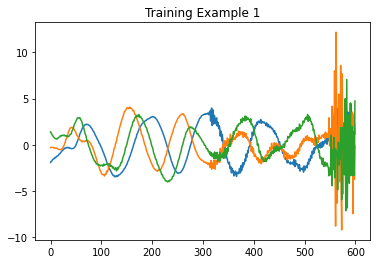

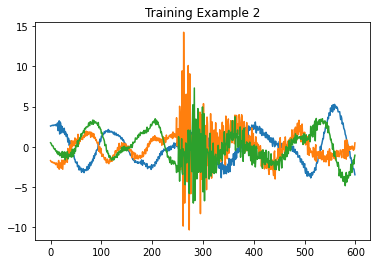

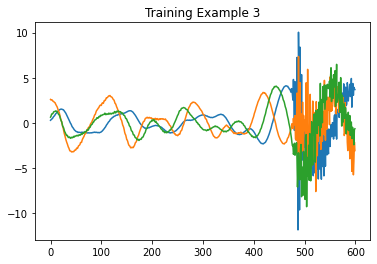

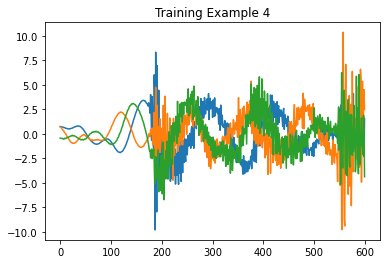

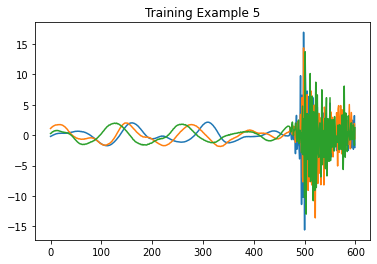

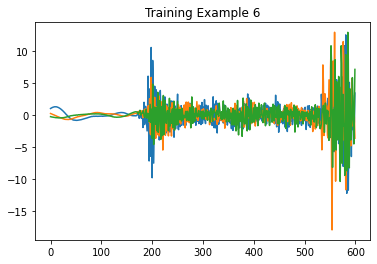

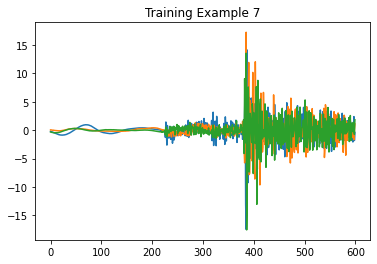

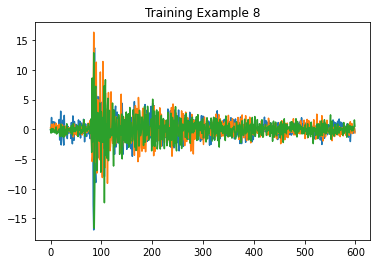

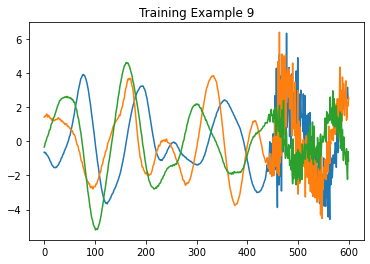

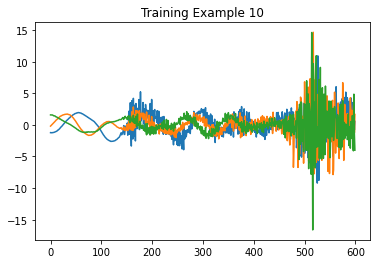

In [9]:
for i, window in enumerate(train_data['X']):
    plt.title(f'Training Example {i+1}')
    plt.plot(window.T)
    plt.show()